# Holmes using USCRN insitu data
We will try to recreate the results from Holmes et. al. by studying the linear relationship between LST and Ka(H) brightness temperature.

We have all stations from the USCRN network LST(lat,lon,time)

* Test Holmes' hypothesis using each station individually.  

* Test it using data from all stations in a given moment in time.  

* Test it using all data from all stations.

$$ HolmesLST(Ka_H) = a * Ka_H + b $$
$$ a = 1.11 $$
$$ b = -15.2 $$


In [1]:
# Libraries
from ismn.interface import ISMN_Interface
import numpy as np
import matplotlib.pyplot as plt 
import xarray as xr
# Custom functions

import sys
sys.path.append("../src")
from processing import load_zip, apply_scaling

# Global
%matplotlib inline

data_path = "../data/raw/Data_separate_files_header_20170101_20171231_10665_aY1v_20231116.zip"
selected_network = "USCRN"

ka_path = '../data/raw/ka.zip'

lst = "surface_temperature"

In [2]:
ismn_data = ISMN_Interface(data_path, parallel=True)

Found existing ismn metadata in ../data/raw/python_metadata/Data_separate_files_header_20170101_20171231_10665_aY1v_20231116.csv.


In [3]:
# Get the ids for the USCRN network and subset from the whole dataset
ids = ismn_data.get_dataset_ids(variable='surface_temperature',
                                filter_meta_dict={'network': selected_network}
                                )
uscrn_data = ismn_data.subset_from_ids(ids)

Found existing ismn metadata in ../data/raw/python_metadata/Data_separate_files_header_20170101_20171231_10665_aY1v_20231116.csv.


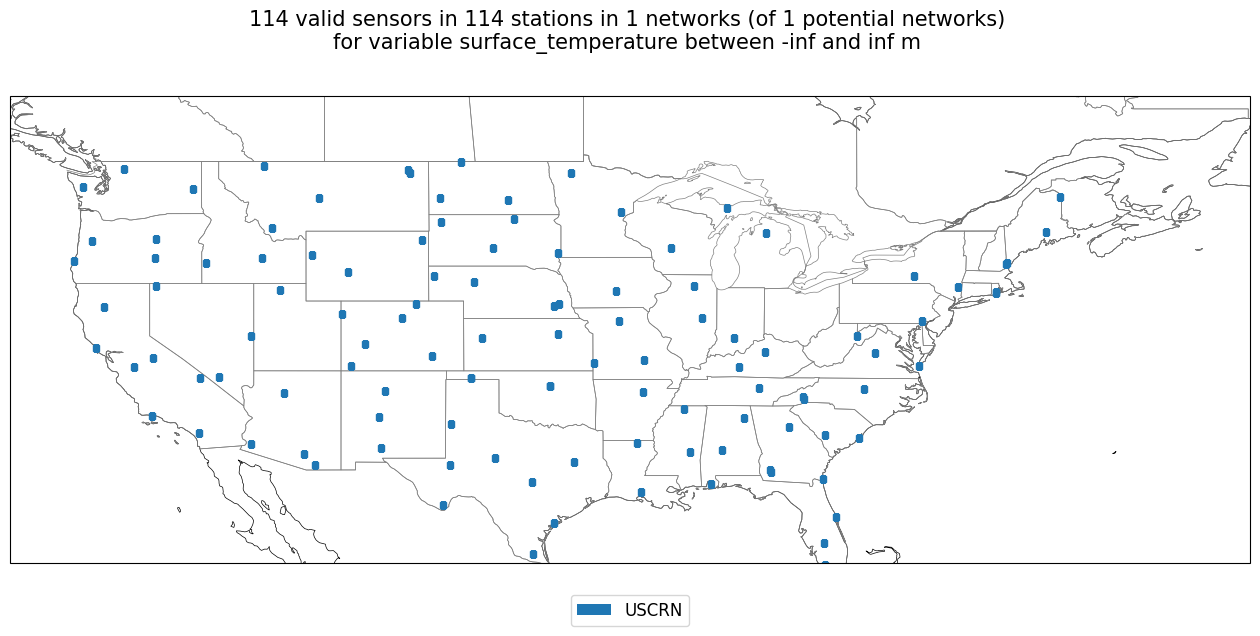

In [4]:
# We can even plot station locations 
import cartopy.crs as ccrs
#plot available station on a map
fig, ax = plt.subplots(1, 1, figsize=(16,10), subplot_kw={'projection': ccrs.PlateCarree()})
uscrn_data.plot_station_locations('surface_temperature', ax=ax, markersize=5, text_scalefactor=3)
ax.set_extent([-128, -57, 26, 47]) # US aproximate coordinate range
plt.show()

In [5]:
# Recover the data only from the sensors that have good timeseries.
ids = uscrn_data.get_dataset_ids("surface_temperature")
valid_sensors = []
for network, station, sensor in uscrn_data.collection.iter_sensors(variable='surface_temperature', depth = [0,0]):
    if np.min(sensor.data["surface_temperature"]) > -100:
        valid_sensors.append((network, station, sensor))
        
len(valid_sensors)

37

In [6]:
# For each sensor, save ascending and descendig passes (6pm and 6am), also lattitude and longitude. save it into a xarray dataset

uscrn_xarray = xr.Dataset()

for network, station, sensor in valid_sensors:
    
    timeseries = uscrn_data[network.name][station.name][sensor.name].data

    ascending_ts = timeseries[timeseries.index.hour == 18]
    descending_ts = timeseries[timeseries.index.hour == 6]

    lon = uscrn_data[network.name][station.name][sensor.name].metadata["longitude"][1]
    lat = uscrn_data[network.name][station.name][sensor.name].metadata["latitude"][1]




In [28]:
descending_ts

,surface_temperature,surface_temperature_flag,surface_temperature_orig_flag
date_time,,,
2017-01-01 06:00:00,14.0,G,0
2017-01-02 06:00:00,5.5,G,0
2017-01-03 06:00:00,5.6,G,0
2017-01-04 06:00:00,8.4,G,0
2017-01-05 06:00:00,8.1,G,0
...,...,...,...
2017-12-26 06:00:00,2.2,G,0
2017-12-27 06:00:00,8.1,G,0
2017-12-28 06:00:00,5.7,G,0


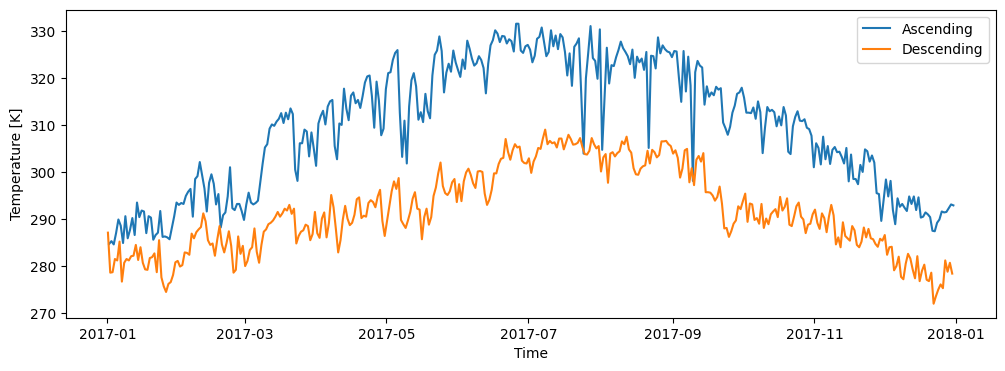

In [7]:
# Use ka band data and get the correlation from a single station (use last from the loop first)
fig, ax = plt.subplots(figsize=(12,4))

ax.plot(ascending_ts["surface_temperature"] + 273.15, label = "Ascending")
ax.plot(descending_ts["surface_temperature"] + 273.15, label = "Descending")
ax.set_ylabel("Temperature [K]")
ax.set_xlabel("Time")
ax.legend()

In [8]:
# retrieve Ka band data:

ka_dataset = load_zip(ka_path)
ka_dataset = apply_scaling(ka_dataset)


Loading zipfile from ../data/raw/ka.zip


100%|██████████| 754/754 [00:18<00:00, 41.89it/s]


Applying scaling


100%|██████████| 3/3 [00:10<00:00,  3.52s/it]


In [9]:
# Select closest pixel to sensor 
node_data = ka_dataset.sel({"lat" : lat, "lon" : lon}, method= "nearest")
node_data

<xarray.Dataset>
Dimensions:                     (time: 730)
Coordinates:
    lon                         float32 -114.3
    lat                         float32 32.82
  * time                        (time) datetime64[ns] 2017-01-01 ... 2017-12-31
    Pass                        (time) <U10 'Ascending' ... 'Descending'
Data variables:
    Brightness Temperature (H)  (time) float32 nan 260.0 263.5 ... 265.5 250.0
    Brightness Temperature (V)  (time) float32 nan 265.3 274.4 ... 277.2 261.5
    Time Information            (time) float32 nan 548.0 ... 1.234e+03 573.0
Attributes: (12/28)
    CDI:                       Climate Data Interface version 1.9.9 (https://...
    Conventions:               CF-1.6
    ProductName:               AMSR2-L3
    GeophysicalName:           Brightness Temperature (36GHz)
    MeanType:                  DayMean
    Projection:                EQR
    ...                        ...
    OrbitDirection:            Ascending
    PlatformShortName:         GCOM-W1
    SensorShortName:           AMSR2
    ECSDataModel:              B.0
    history:                   Tue Apr 27 13:13:52 2021: cdo remapbil,/media/...
    CDO:                       Climate Data Operators version 1.9.9 (https://...

In [10]:
ka_ascending = node_data.where(node_data.Pass == "Ascending", drop=True)
ka_descending = node_data.where(node_data.Pass == "Descending", drop=True)

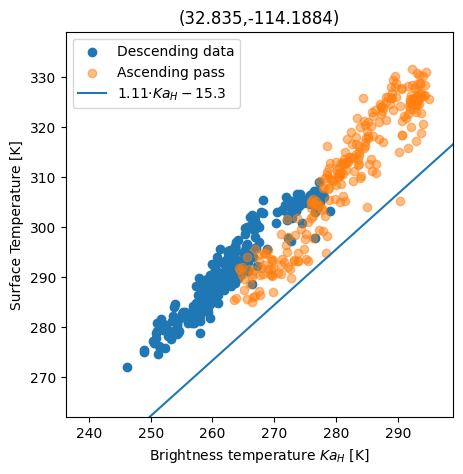

In [23]:
fig, ax = plt.subplots(1,1, figsize=(5,5))
# Descending pass #
y = descending_ts['surface_temperature'].values + 273.15
x = ka_descending["Brightness Temperature (H)"][:-1] # We dont have measurements for the last passing for some reason

ax.scatter(x,y, label = "Descending data")
ax.set_xlabel("Brightness temperature $Ka_H$ [K]")
ax.set_ylabel("Surface Temperature [K]")

# Spans
ax.set_xlim((min(x)-10, max(x)+20))
ax.set_ylim((min(y)-10, max(y)+30))
ax.set_title(f"({lat},{lon})")

# Ascending Pass #
y = ascending_ts['surface_temperature'].values + 273.15
x = ka_ascending["Brightness Temperature (H)"][:-1] # We dont have measurements for the last passing for some reason
ax.scatter(x,y, label = "Ascending pass", alpha = 0.5)

# Holmes
ax.axline(slope= 1.11, xy1= (0,-15.3), label = "$1.11·Ka_H -15.3$") # Holmes' regression

ax.legend()
fig.show()

In [61]:
ka_ascending["Brightness Temperature (H)"][:-1].shape

(364,)

In [24]:
# TODO: Represent all data from all stations separatelly and see if Holmes' LST holds
# TODO: Try with soil_temperature instead